In [2]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
# import pymysql  # 导入数据库模块

from datetime import datetime # 时间模块
import statsmodels.formula.api as smf  # OLS regression

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates

from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块

#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

In [3]:
# 导入市场回报率数据
from pandas.tseries.offsets import MonthEnd
Market_ret = pd.read_csv('Marketret_mon_stock2024.csv')
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0)
Market_ret.set_index('month', inplace=True)
# 确保数据按时间递增排序
Market_ret.sort_index(inplace=True)
# 删除 CSV 文件中自动生成的 Unnamed: 0 列
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])
Market_ret

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4


In [4]:
inflation = pd.read_csv('inflation.csv')
inflation['month'] = pd.to_datetime(inflation['month'],format='%Y/%m/%d')
inflation.set_index('month',inplace=True)
inflation.sort_values(by=['month'],axis=0,ascending=True)

,cpi
month,
1987-01-31,5.1
1987-02-28,5.4
1987-03-31,5.8
1987-04-30,6.7
1987-05-31,7.6
...,...
2025-03-31,-0.1
2025-04-30,-0.1
2025-05-31,-0.1


In [5]:
# 导入日度市场回报率数据并计算已实现波动率
Market_ret_day = pd.read_excel('Marketret_day_stock2024.xlsx')
Market_ret_day['Day'] = pd.to_datetime(Market_ret_day['Day'],format='%Y-%m-%d')
Market_ret_day.set_index('Day',inplace=True)
Market_ret_day.sort_index(inplace=True)

# Calculate monthly realized variance (RV) by summing squared excess returns
Market_variance = Market_ret_day.resample('ME').apply(lambda df: pd.Series({
    'RV': (df['er']**2).sum(),
    'RV1': (df['er']**2).sum() + 2*(df['er']*df['er1']).sum(),
    'RV2': (df['er']**2).sum() + 2*(df['er']*df['er1']).sum() + 2*(df['er']*df['er2']).sum(),
    'RV3': (df['er']**2).sum() + 2*(df['er']*df['er1']).sum() + 2*(df['er']*df['er2']).sum() + 2*(df['er']*df['er3']).sum()
}))

Market_variance['var'] = Market_ret_day.resample('ME')['er'].var()
Market_variance.index.name = 'month'

# 对于 RV1 列的每一个值，如果它大于等于 0 ，就保留它原来的数值；如果它小于 0（异常值），就用 RV 列对应的数值来替换它
Market_variance['RV1'] = Market_variance['RV1'].where(Market_variance['RV1']>=0, Market_variance['RV'])
Market_variance['RV2'] = Market_variance['RV2'].where(Market_variance['RV2']>=0, Market_variance['RV1'])
Market_variance['RV3'] = Market_variance['RV3'].where(Market_variance['RV3']>=0, Market_variance['RV2'])
Market_variance

,RV,RV1,RV2,RV3,var
month,,,,,
1990-12-31,0.011709,0.030732,0.046608,0.058424,0.000395
1991-01-31,0.000690,0.001566,0.002593,0.003461,0.000030
1991-02-28,0.000418,0.000707,0.000853,0.000763,0.000024
1991-03-31,0.001229,0.002925,0.004650,0.006369,0.000014
1991-04-30,0.000855,0.001973,0.003364,0.004531,0.000010
...,...,...,...,...,...
2024-08-31,0.000881,0.000823,0.000487,0.000487,0.000040
2024-09-30,0.012481,0.023868,0.034838,0.041347,0.000593
2024-10-31,0.011652,0.007954,0.006707,0.006707,0.000685


In [6]:
# 导入价格比率数据
price_dividend = pd.read_csv('Price_dividend_mon2024.csv')
price_dividend['month'] = pd.date_range(start='1990-12-31', end='2024-12-31', freq='ME')
price_dividend.set_index('month', inplace=True)
price_dividend.sort_index(inplace=True)
price_dividend = price_dividend.drop(columns=['Unnamed: 0'])

price_earning = pd.read_csv('Price_earnings_mon2024.csv')
price_earning['month'] = pd.date_range(start='1991-01-31', end='2024-12-31', freq='ME')
price_earning.set_index('month', inplace=True)
price_earning.sort_index(inplace=True)

price_bookvalue = pd.read_csv('Price_bookvalue_mon2024.csv')
price_bookvalue['month'] = pd.date_range(start='1990-12-31', end='2024-12-31', freq='ME')
price_bookvalue.set_index('month', inplace=True)
price_bookvalue.sort_index(inplace=True)
price_bookvalue

,pb
month,
1990-12-31,1.886568
1991-01-31,2.080065
1991-02-28,1.949285
1991-03-31,1.560324
1991-04-30,1.970330
...,...
2024-08-31,0.097936
2024-09-30,0.275764
2024-10-31,0.254341


In [7]:
Turnover = pd.read_csv('Turnover_mon2024.csv')
Turnover['month'] = pd.date_range(start='1990-12-31', periods=len(Turnover), freq='ME')
Turnover.set_index('month', inplace=True)
Turnover.sort_index(inplace=True)
Turnover

,to_v,to_m
month,,
1990-12-31,0.009403,0.009754
1991-01-31,0.012623,0.031899
1991-02-28,0.042994,0.046496
1991-03-31,0.006471,0.016755
1991-04-30,0.014430,0.026691
...,...,...
2024-08-31,0.205272,0.203924
2024-09-30,0.235540,0.231543
2024-10-31,0.424766,0.464635


In [8]:
# 合并所有数据,以 month 列为 “键”，将两个表中 month 相同的行合并到一起
reg_data = pd.merge(Market_ret,inflation,on = 'month')
reg_data = pd.merge(reg_data,Market_variance,on = 'month')
reg_data = pd.merge(reg_data,price_dividend,on = 'month')
reg_data = pd.merge(reg_data,price_earning,on = 'month')
reg_data = pd.merge(reg_data,price_bookvalue,on = 'month')
reg_data = pd.merge(reg_data,Turnover,on = 'month')

reg_data = reg_data[['MarketR','rfmonth','ret','cpi','RV','RV1','RV2','RV3','var','pd','pe','pb','to_v','marketret3','marketret6','marketret12']]
reg_data

,MarketR,rfmonth,ret,cpi,RV,RV1,RV2,RV3,var,pd,pe,pb,to_v,marketret3,marketret6,marketret12
month,,,,,,,,,,,,,,,,
1991-01-31,0.029998,0.006930,0.023068,2.2,0.000690,0.001566,0.002593,0.003461,0.000030,NaN,4.466562,2.080065,0.012623,-0.084127,-0.305662,0.254049
1991-02-28,0.010203,0.006930,0.003273,1.0,0.000418,0.000707,0.000853,0.000763,0.000024,NaN,4.501042,1.949285,0.042994,-0.183573,-0.384745,0.241492
1991-03-31,-0.099663,0.006930,-0.106593,1.6,0.001229,0.002925,0.004650,0.006369,0.000014,NaN,4.112082,1.560324,0.006471,-0.252928,-0.445049,0.288857
1991-04-30,-0.079652,0.006651,-0.086303,1.3,0.000855,0.001973,0.003364,0.004531,0.000010,NaN,4.111121,1.970330,0.014430,-0.234776,-0.394937,0.691749
1991-05-31,-0.074521,0.006092,-0.080613,3.6,0.000480,0.001262,0.002119,0.002949,0.000005,NaN,4.182871,1.901101,0.039698,-0.236294,0.181673,1.542701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,0.001118,-0.032586,0.6,0.000881,0.000823,0.000487,0.000487,0.000040,10.728048,2.502897,0.097936,0.205272,0.151050,NaN,NaN
2024-09-30,0.195992,0.001118,0.194874,0.4,0.012481,0.023868,0.034838,0.041347,0.000593,10.889979,2.675435,0.275764,0.235540,0.200147,NaN,NaN
2024-10-31,-0.003409,0.001118,-0.004527,0.3,0.011652,0.007954,0.006707,0.006707,0.000685,10.862945,2.635010,0.254341,0.424766,0.000228,NaN,NaN


In [9]:
# 创建滞后变量
reg_data['lRV'] = reg_data['RV'].shift(1)
reg_data['lRV1'] = reg_data['RV1'].shift(1)
reg_data['lRV2'] = reg_data['RV2'].shift(1)
reg_data['lRV3'] = reg_data['RV3'].shift(1)
reg_data['lcpi'] = reg_data['cpi'].shift(2)
reg_data['lpd'] = reg_data['pd'].shift(1)
reg_data['lpe'] = reg_data['pe'].shift(1)
reg_data['lpb'] = reg_data['pb'].shift(1)
reg_data['lto_v'] = reg_data['to_v'].shift(1)
reg_data

,MarketR,rfmonth,ret,cpi,RV,RV1,RV2,RV3,var,pd,pe,pb,to_v,marketret3,marketret6,marketret12,lRV,lRV1,lRV2,lRV3,lcpi,lpd,lpe,lpb,lto_v
month,,,,,,,,,,,,,,,,,,,,,,,,,
1991-01-31,0.029998,0.006930,0.023068,2.2,0.000690,0.001566,0.002593,0.003461,0.000030,NaN,4.466562,2.080065,0.012623,-0.084127,-0.305662,0.254049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.010203,0.006930,0.003273,1.0,0.000418,0.000707,0.000853,0.000763,0.000024,NaN,4.501042,1.949285,0.042994,-0.183573,-0.384745,0.241492,0.000690,0.001566,0.002593,0.003461,NaN,NaN,4.466562,2.080065,0.012623
1991-03-31,-0.099663,0.006930,-0.106593,1.6,0.001229,0.002925,0.004650,0.006369,0.000014,NaN,4.112082,1.560324,0.006471,-0.252928,-0.445049,0.288857,0.000418,0.000707,0.000853,0.000763,2.2,NaN,4.501042,1.949285,0.042994
1991-04-30,-0.079652,0.006651,-0.086303,1.3,0.000855,0.001973,0.003364,0.004531,0.000010,NaN,4.111121,1.970330,0.014430,-0.234776,-0.394937,0.691749,0.001229,0.002925,0.004650,0.006369,1.0,NaN,4.112082,1.560324,0.006471
1991-05-31,-0.074521,0.006092,-0.080613,3.6,0.000480,0.001262,0.002119,0.002949,0.000005,NaN,4.182871,1.901101,0.039698,-0.236294,0.181673,1.542701,0.000855,0.001973,0.003364,0.004531,1.6,NaN,4.111121,1.970330,0.014430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,0.001118,-0.032586,0.6,0.000881,0.000823,0.000487,0.000487,0.000040,10.728048,2.502897,0.097936,0.205272,0.151050,NaN,NaN,0.001878,0.001692,0.002073,0.001693,0.2,10.778043,2.544499,0.127471,0.211110
2024-09-30,0.195992,0.001118,0.194874,0.4,0.012481,0.023868,0.034838,0.041347,0.000593,10.889979,2.675435,0.275764,0.235540,0.200147,NaN,NaN,0.000881,0.000823,0.000487,0.000487,0.5,10.728048,2.502897,0.097936,0.205272
2024-10-31,-0.003409,0.001118,-0.004527,0.3,0.011652,0.007954,0.006707,0.006707,0.000685,10.862945,2.635010,0.254341,0.424766,0.000228,NaN,NaN,0.012481,0.023868,0.034838,0.041347,0.6,10.889979,2.675435,0.275764,0.235540


# 样本外预测 Out-Of-Sample

## 引言:为什么需要样本外预测?

我们前面所做的所有回归叫做**样本内回归(In-Sample Regression)**。样本内回归使用全部可用数据来估计模型参数,然后评估模型的拟合效果。

### 样本内预测的局限性

**过度拟合问题(Overfitting)**: 样本内预测容易产生过度拟合,模型可能捕捉到数据中的噪音而非真实的规律。这会导致:
- 样本内R²过高,给人虚假的信心
- 模型在新数据上表现很差
- 参数估计不稳定

**前瞻性偏差(Look-Ahead Bias)**: 在实际投资中,我们不可能使用"未来"的数据。如果用全样本数据估计参数后再评估预测能力,就等于偷看了答案,这在学术上是不被接受的。

**真实世界的约束**: 在现实中,投资者只能:
- 站在当前时间点 $t$
- 使用截至 $t$ 时刻的历史数据
- 做出关于 $t+1$ 的预测决策

因此,样本外预测(Out-of-Sample Prediction)才能真实反映模型的预测能力。

---

## 理论框架

### 1. 滚动窗口回归(Rolling Window Regression)

假设我们的观测样本共有 $T$ 期(从 $t=1$ 到 $t=T$),样本外预测采用**扩展窗口(Expanding Window)**或**滚动窗口(Rolling Window)**方法:

**扩展窗口方法**(本notebook采用):
- 在时间 $t$,使用 $\{1, 2, ..., t\}$ 的所有历史数据
- 估计预测模型: 
$$
r_{k} = \alpha + \beta \cdot x_{k-1} + \epsilon_{k}, \quad k=1,2,3,...,t
$$
- 得到估计参数 $\hat{\alpha}_{t}$ 和 $\hat{\beta}_{t}$
- 随着 $t$ 增加,样本量逐渐扩大

**滚动窗口方法**(固定窗口长度):
- 在时间 $t$,使用固定长度的历史数据 $\{t-w+1, ..., t\}$
- 窗口长度 $w$ 保持不变(例如60个月)
- 适用于参数随时间变化的情况

### 2. 预测模型 vs 基准模型

**预测模型(Augmented Model)**:
使用预测变量 $x_t$ 来预测 $t+1$ 期收益率:
$$
\hat{r}_{a,t+1} = \hat{\alpha}_{t} + \hat{\beta}_{t} \cdot x_{t}
$$

其中:
- $\hat{\alpha}_{t}, \hat{\beta}_{t}$ 是用 $\{1,...,t\}$ 数据估计的参数
- $x_t$ 是 $t$ 时刻可观测的预测变量
- $\hat{r}_{a,t+1}$ 是对 $t+1$ 期收益率的预测

**基准模型(Benchmark Model - Historical Mean)**:
不使用任何额外信息,仅用历史均值作为预测:
$$
\hat{r}_{b,t+1} = \bar{r}_t = \frac{1}{t}\sum_{i=1}^{t}{r_i}
$$

这个基准模型代表了"无预测能力"的null hypothesis。如果我们的预测模型无法战胜历史均值,说明预测变量 $x$ 没有提供有用的信息。

### 3. 多变量扩展

对于多个预测变量 $\mathbf{x}_t = (x_{1,t}, x_{2,t}, ..., x_{p,t})'$,模型变为:
$$
r_{k} = \alpha + \beta_1 x_{1,k-1} + \beta_2 x_{2,k-1} + ... + \beta_p x_{p,k-1} + \epsilon_{k}
$$

预测公式:
$$
\hat{r}_{a,t+1} = \hat{\alpha}_{t} + \hat{\beta}_{1,t} x_{1,t} + \hat{\beta}_{2,t} x_{2,t} + ... + \hat{\beta}_{p,t} x_{p,t}
$$

---

## 评价指标

### 预测误差的定义

对于样本外预测期 $t = t_0, t_0+1, ..., T-1$,定义预测误差:

$$
\begin{aligned}
\hat{u}_{a, t+1} &= \hat{r}_{a,t+1} - r_{t+1} \quad \text{(预测模型的预测误差)}\\
\hat{u}_{b, t+1} &= \hat{r}_{b,t+1} - r_{t+1} \quad \text{(基准模型的预测误差)}
\end{aligned}
$$

其中:
- $r_{t+1}$ 是真实收益率
- $t_0$ 是样本外预测的起始点(通常取 $t_0 = T/3$ 或 $T/2$)

我们通过比较两个模型的**均方预测误差(Mean Squared Prediction Error, MSPE)**来评估预测能力。

### 1. 样本外R² (Out-of-Sample $R^2$, Campbell and Thompson 2008)

$$
R^2_{OOS} = 1 - \frac{MSPE_a}{MSPE_b} = 1 - \frac{\sum_{t=t_0}^{T-1}(\hat{u}_{a, t+1})^2}{\sum_{t=t_0}^{T-1}(\hat{u}_{b, t+1})^2}
$$

**解释**:
- $R^2_{OOS} > 0$: 预测模型优于历史均值,预测变量 $x$ 提供了有用信息
- $R^2_{OOS} = 0$: 预测模型与历史均值表现相同
- $R^2_{OOS} < 0$: 预测模型表现更差,不如使用历史均值

**重要性质**:
- 样本外R²通常**远小于**样本内R²
- 即使样本外R²很小(如1%-5%),在统计上也可能显著
- Welch and Goyal (2008)发现大多数预测变量的样本外R²为负!

**实践意义**:
- $R^2_{OOS} > 0.5\%$ 已经被认为有经济意义
- $R^2_{OOS} > 1\%$ 表示较强的预测能力
- 需要统计检验来判断是否显著不为0

### 2. ENC-NEW 检验统计量 (Clark and McCracken 2001)

$$
ENC-NEW = (T-t_0) \cdot \frac{ \sum_{t=t_0}^{T-1}\left[\hat{u}_{b, t+1}^{2}-\hat{u}_{b, t+1} \cdot \hat{u}_{a, t+1}\right]}{\sum_{t=t_0}^{T-1} \hat{u}_{a, t+1}^{2}}
$$

**含义**: Encompassing Test for Nested Models
- 检验基准模型是否"包含"了预测模型的所有信息
- 原假设 $H_0$: 预测模型没有额外的预测能力
- 如果 ENC-NEW 值较大且显著,拒绝原假设

**统计推断**:
- 在嵌套模型(nested models)情况下使用
- 渐近分布是非标准的,需要使用bootstrap或临界值表
- 一般 ENC-NEW > 1.96 (5%显著性水平) 认为显著

### 3. MSE-F 检验统计量 (McCracken 2007)

$$
MSE-F = (T-t_0) \cdot \frac{\sum_{t=t_0}^{T-1}\left[\hat{u}_{b, t+1}^{2}-\hat{u}_{a, t+1}^{2}\right]}{ \sum_{t=t_0}^{T-1} \hat{u}_{a, t+1}^{2}}
$$

**含义**: Mean Squared Error F-test
- 直接比较两个模型的MSPE差异
- 原假设 $H_0$: 预测模型的MSPE ≥ 基准模型的MSPE
- MSE-F 与 $R^2_{OOS}$ 单调相关: $MSE-F = (T-t_0) \cdot \frac{R^2_{OOS}}{1-R^2_{OOS}}$

**关系式**:
$$
R^2_{OOS} = \frac{MSE-F}{T-t_0 + MSE-F}
$$

**统计推断**:
- MSE-F > 0 等价于 $R^2_{OOS} > 0$
- 需要特殊的临界值(因为是单边检验)
- 一般 MSE-F > 1.5-2.0 认为有统计意义

### 4. 其他重要指标

**Diebold-Mariano (DM) 检验**: 用于比较两个预测模型的MSPE是否显著不同

**方向准确率(Directional Accuracy)**: 
$$
DA = \frac{1}{T-t_0}\sum_{t=t_0}^{T-1} I\left(\text{sign}(\hat{r}_{a,t+1}) = \text{sign}(r_{t+1})\right)
$$
衡量预测方向(涨跌)的准确性

---

## 关键参数选择

### 初始样本比例 $t_0/T$

**常见选择**:
- $t_0 = T/3$: 使用前1/3数据作为初始训练期
- $t_0 = T/2$: 使用前1/2数据作为初始训练期
- $t_0 = 60$ (月度数据): 固定使用前5年数据

**权衡**:
- $t_0$ 太小: 初始参数估计不稳定
- $t_0$ 太大: 样本外评估期太短,结果不可靠
- 建议: 保证样本外期至少有50-100个观测

### 预测变量的选择

**常用预测变量**(本notebook中):
1. **已实现波动率(RV)**: 市场风险的度量
2. **通货膨胀率(CPI)**: 宏观经济状态
3. **市盈率(PE)、市净率(PB)、股息率(PD)**: 估值指标
4. **换手率(Turnover)**: 市场情绪和流动性

**预测变量的理想特征**:
- 经济上合理(有理论支持)
- 统计上显著(t统计量)
- 样本外稳健(不同期间表现一致)

---

## 学术文献与背景

**经典文献**:
1. **Campbell and Thompson (2008, JFE)**: "Predicting Excess Stock Returns Out of Sample"
   - 提出样本外R²的概念
   - 发现加入理论约束可以提高样本外表现

2. **Welch and Goyal (2008, RFS)**: "A Comprehensive Look at the Empirical Performance of Equity Premium Prediction"
   - 系统检验了15个常用预测变量
   - 发现大多数变量在样本外表现不佳

3. **Rapach et al. (2010, RFS)**: "Out-of-Sample Equity Premium Prediction"
   - 组合预测方法优于单一模型
   - 经济约束和预测组合是提高表现的关键

4. **Clark and McCracken (2001, Econometrica)**: 
   - 提出ENC-NEW检验统计量
   - 解决嵌套模型比较的推断问题

**中国市场研究**:
- 已实现波动率在中国市场也有显著预测能力
- 估值指标(PE/PB)的预测能力因市场发展阶段而异
- 情绪指标在中国市场表现突出

---

## 实践注意事项

⚠️ **重要提醒**:

1. **数据挖掘(Data Snooping)**: 不要尝试太多变量组合,否则产生的"好结果"可能是偶然
2. **参数不稳定性**: 预测模型的参数可能随时间变化,需要定期重新估计
3. **结构性断点**: 市场制度变化可能导致历史关系失效
4. **交易成本**: 样本外预测能力需要足够大才能覆盖交易成本
5. **模型风险**: 所有模型都是简化的,现实中存在模型设定错误的风险

**稳健性检验**:
- 不同样本期间
- 不同初始样本比例
- 不同预测频率(月度/季度/年度)
- 子样本分析(牛市/熊市)

In [10]:
# 查看数据(最后十位)
reg_data.tail(10)

,MarketR,rfmonth,ret,cpi,RV,RV1,RV2,RV3,var,pd,pe,pb,to_v,marketret3,marketret6,marketret12,lRV,lRV1,lRV2,lRV3,lcpi,lpd,lpe,lpb,lto_v
month,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-31,0.016715,0.001200,0.015515,0.1,0.001174,0.001450,0.000916,0.001054,0.000058,10.831573,2.559242,0.195646,0.269898,0.022495,-0.052033,NaN,0.004431,0.005019,0.007816,0.009602,-0.8,10.813148,2.537486,0.189807,0.216073
2024-04-30,0.016724,0.001200,0.015524,0.3,0.002223,0.001160,0.002283,0.000480,0.000116,10.837655,2.605339,0.189505,0.252094,-0.034238,0.116460,NaN,0.001174,0.001450,0.000916,0.001054,0.7,10.831573,2.559242,0.195646,0.269898
2024-05-31,-0.007371,0.001200,-0.008571,0.3,0.001086,0.000785,0.000768,0.001512,0.000057,10.838736,2.599313,0.182497,0.230006,-0.049633,0.094295,NaN,0.002223,0.001160,0.002283,0.000480,0.1,10.837655,2.605339,0.189505,0.252094
2024-06-30,-0.039499,0.001200,-0.040699,0.2,0.000934,0.000445,0.000867,0.001179,0.000047,10.770461,2.557868,0.136221,0.184419,-0.072709,0.113343,NaN,0.001086,0.000785,0.000768,0.001512,0.3,10.838736,2.599313,0.182497,0.230006
2024-07-31,0.000560,0.001184,-0.000624,0.5,0.001878,0.001692,0.002073,0.001693,0.000085,10.778043,2.544499,0.127471,0.211110,0.155581,0.156368,NaN,0.000934,0.000445,0.000867,0.001179,0.3,10.770461,2.557868,0.136221,0.184419
2024-08-31,-0.031468,0.001118,-0.032586,0.6,0.000881,0.000823,0.000487,0.000487,0.000040,10.728048,2.502897,0.097936,0.205272,0.151050,NaN,NaN,0.001878,0.001692,0.002073,0.001693,0.2,10.778043,2.544499,0.127471,0.211110
2024-09-30,0.195992,0.001118,0.194874,0.4,0.012481,0.023868,0.034838,0.041347,0.000593,10.889979,2.675435,0.275764,0.235540,0.200147,NaN,NaN,0.000881,0.000823,0.000487,0.000487,0.5,10.728048,2.502897,0.097936,0.205272
2024-10-31,-0.003409,0.001118,-0.004527,0.3,0.011652,0.007954,0.006707,0.006707,0.000685,10.862945,2.635010,0.254341,0.424766,0.000228,NaN,NaN,0.012481,0.023868,0.034838,0.041347,0.6,10.889979,2.675435,0.275764,0.235540
2024-11-30,0.009724,0.001118,0.008606,0.2,0.004019,0.004118,0.005938,0.003775,0.000201,10.858076,2.643930,0.263924,0.493320,NaN,NaN,NaN,0.011652,0.007954,0.006707,0.006707,0.4,10.862945,2.635010,0.254341,0.424766


In [11]:
# 简单示例：使用已实现波动率预测市场收益率
data = reg_data['2000-01':'2024-12'].copy()
data = data.dropna()  # 删除缺失值
model_pre = 0
mean_pre = 0

for i in range(int(len(data)/3), len(data) - 1):
    # 选择数据
    data_reg = data[0:i]
    # 拟合回归模型：用训练集估计 ret = α + β*lRV3
    model =smf.ols(formula='ret ~ lRV3', data=data_reg).fit(displ=False)
    # 计算模型预测误差平方：(模型预测值 - 真实值)^2
    r_a = (model.predict(data[i:i+1][['lRV3']]) - data[i:i+1]['ret'])**2
    # 计算均值基准预测误差平方：(训练集平均收益 - 真实值)^2
    r_b = (np.mean(data_reg['ret']) - data[i:i+1]['ret'])**2
    r_a = r_a.values
    r_b = r_b.values
    # 累计误差平方和
    model_pre = model_pre + r_a
    mean_pre = mean_pre + r_b

oos = 1 - model_pre/mean_pre
print("使用已实现波动率(RV3)的样本外R2是:",oos)

使用已实现波动率(RV3)的样本外R2是: [-0.06932759]


In [12]:
# 通用样本外预测函数 (简化版)
data = reg_data['2000-01':'2024-12'].copy()
data = data.dropna()  # 删除缺失值

def out_of_sample_simple(data,y,x,initial_sample_fractions):
    model_pre = 0
    mean_pre = 0
    # 计算初始训练集大小（总数据量 × 比例，转为整数）
    initial_sample = int(len(data)*initial_sample_fractions)

    # 模型
    predictor_formula = "+".join(x)
    formula = f'{y} ~ {predictor_formula}'

    for i in range(initial_sample, len(data) - 1):
        # 选择数据
        data_reg = data[0:i]
        model =smf.ols(formula, data=data_reg).fit(displ=False)
        r_a = (model.predict(data[i:i+1][x]) - data[i:i+1][y])**2
        r_b = (np.mean(data_reg[y]) - data[i:i+1][y])**2
        r_a = r_a.values
        r_b = r_b.values
        model_pre = model_pre + r_a
        mean_pre = mean_pre + r_b

    oos = 1 - model_pre/mean_pre
    return oos

# 测试不同预测变量
print("单变量模型:")
print("RV3模型:", out_of_sample_simple(data,'ret',['lRV3'],0.5))
print("CPI模型:", out_of_sample_simple(data,'ret',['lcpi'],0.5))
print("PD模型:", out_of_sample_simple(data,'ret',['lpd'],0.5))
print("\n多变量模型:")
print("RV3+CPI:", out_of_sample_simple(data,'ret',['lRV3','lcpi'],0.5))
print("RV3+PD:", out_of_sample_simple(data,'ret',['lRV3','lpd'],0.5))
print("RV3+CPI+PD:", out_of_sample_simple(data,'ret',['lRV3','lcpi','lpd'],0.5))

单变量模型:
RV3模型: [-0.08398473]
CPI模型: [-0.02056036]
PD模型: [-0.00564408]

多变量模型:
RV3+CPI: [-0.15904403]
RV3+PD: [-0.08972757]
RV3+CPI+PD: [-0.18643754]


In [13]:
# 测试不同初始样本比例的影响
sample_fractions = np.linspace(0.1,0.9,9)

results = {}

for i in sample_fractions:
    results[i] = out_of_sample_simple(data,'ret',['lRV3','lcpi','lpd'],i)

# 打印数值i
print("初始样本比例对样本外R2的影响:")
for i, j in results.items():
    print(f"初始样本比例 {round(i,1)}: OOS R2 = {j[0]:.6f}")

初始样本比例对样本外R2的影响:
初始样本比例 0.1: OOS R2 = -0.033798
初始样本比例 0.2: OOS R2 = 0.003662
初始样本比例 0.3: OOS R2 = 0.008066
初始样本比例 0.4: OOS R2 = -0.171586
初始样本比例 0.5: OOS R2 = -0.186438
初始样本比例 0.6: OOS R2 = -0.230610
初始样本比例 0.7: OOS R2 = -0.107323
初始样本比例 0.8: OOS R2 = -0.158921
初始样本比例 0.9: OOS R2 = -0.183142


In [14]:
# 完整的样本外检验（包含ENC-NEW和MSE-F统计量）
# benchmark model 是基准模型，为历史均值
# augment model 是比较模型，是我们要添加的预测变量

data = reg_data['2000-01':'2024-12'].copy()
data = data.dropna()  # 删除缺失值
benchmark = 0.00
augment = 0.00
ab = 0.00

for i in range(int(len(data) / 3), len(data) - 1):
    data_reg = data[0:i]
    model1 = smf.ols('ret ~ lRV3', data_reg).fit(displ=False)
    r_a = (model1.predict(data[i:i + 1][['lRV3']]) - data[i:i + 1]['ret'])**2
    r_b = (np.mean(data[0:i]['ret']) - data[i:i + 1]['ret'])**2
    r_ab = (model1.predict(data[i:i + 1][['lRV3']]) - data[i:i + 1]['ret']) * (
        np.mean(data[0:i]['ret']) - data[i:i + 1]['ret'])
    r_a = r_a.values
    r_b = r_b.values
    r_ab = r_ab.values
    augment = augment + r_a
    benchmark += r_b
    ab += r_ab
# 样本外R²（OOS R²）：基础指标，衡量相对预测能力
oos = 1 - augment / benchmark
# ENC-NEW统计量：检验增强模型的“增量预测价值”
ENCNEW = ((benchmark - ab) / augment) * (len(data) - int(len(data) / 3))
#. MSE-F统计量：检验MSE差异的统计显著性
MSEF = (benchmark - augment) / augment * (len(data) - int(len(data) / 3))

print('使用已实现波动率(RV3)预测:')
print('样本外的R方是', oos)
print('样本外的ENC-NEW是', ENCNEW)
print('样本外的MSE-F是', MSEF)

使用已实现波动率(RV3)预测:
样本外的R方是 [-0.06932759]
样本外的ENC-NEW是 [-2.61425209]
样本外的MSE-F是 [-12.51274624]


In [15]:
# 使用多个预测变量: RV3 + PD
data = reg_data['2000-01':'2024-12'].copy()
data = data.dropna()  # 删除缺失值
benchmark = 0.00
augment = 0.00
ab = 0.00

for i in range(int(len(data) / 3), len(data) - 1):
    data_reg = data[0:i]
    model1 = smf.ols('ret ~ lRV3 + lpd', data_reg).fit(displ=False)
    r_a = (model1.predict(data[i:i + 1][['lRV3','lpd']]) - data[i:i + 1]['ret'])**2
    r_b = (np.mean(data[0:i]['ret']) - data[i:i + 1]['ret'])**2
    r_ab = (model1.predict(data[i:i + 1][['lRV3','lpd']]) - data[i:i + 1]['ret']) * (
        np.mean(data[0:i]['ret']) - data[i:i + 1]['ret'])
    r_a = r_a.values
    r_b = r_b.values
    r_ab = r_ab.values
    augment = augment + r_a
    benchmark += r_b
    ab += r_ab

oos = 1 - augment / benchmark
ENCNEW = ((benchmark - ab) / augment) * (len(data) - int(len(data) / 3))
MSEF = (benchmark - augment) / augment * (len(data) - int(len(data) / 3))

print('使用RV3+PD预测:')
print('样本外的R方是', oos)
print('样本外的ENC-NEW是', ENCNEW)
print('样本外的MSE-F是', MSEF)

使用RV3+PD预测:
样本外的R方是 [-0.07519754]
样本外的ENC-NEW是 [-3.03863511]
样本外的MSE-F是 [-13.49810175]


In [16]:
# 使用多个预测变量: RV3 + PD + CPI
data = reg_data['2000-01':'2024-12'].copy()
data = data.dropna()  # 删除缺失值
benchmark = 0.00
augment = 0.00
ab = 0.00

for i in range(int(len(data) / 3), len(data) - 1):
    data_reg = data[0:i]
    model1 = smf.ols('ret ~ lRV3 + lpd + lcpi', data_reg).fit(displ=False)
    r_a = (model1.predict(data[i:i + 1][['lRV3','lpd','lcpi']]) - data[i:i + 1]['ret'])**2
    r_b = (np.mean(data[0:i]['ret']) - data[i:i + 1]['ret'])**2
    r_ab = (model1.predict(data[i:i + 1][['lRV3','lpd','lcpi']]) - data[i:i + 1]['ret']) * (
        np.mean(data[0:i]['ret']) - data[i:i + 1]['ret'])
    r_a = r_a.values
    r_b = r_b.values
    r_ab = r_ab.values
    augment = augment + r_a
    benchmark += r_b
    ab += r_ab

oos = 1 - augment / benchmark
ENCNEW = ((benchmark - ab) / augment) * (len(data) - int(len(data) / 3))
MSEF = (benchmark - augment) / augment * (len(data) - int(len(data) / 3))

print('使用RV3+PD+CPI预测:')
print('样本外的R方是', oos)
print('样本外的ENC-NEW是', ENCNEW)
print('样本外的MSE-F是', MSEF)

使用RV3+PD+CPI预测:
样本外的R方是 [-0.01992838]
样本外的ENC-NEW是 [11.1652462]
样本外的MSE-F是 [-3.77102739]


# 更具一般性的函数
修改输入数据和公式

In [17]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

def out_of_sample(data, response_var, predictor_vars):
    benchmark = 0.00
    augment = 0.00
    ab = 0.00

    # 构建模型公式
    predictor_formula = ' + '.join(predictor_vars)
    formula = f'{response_var} ~ {predictor_formula}'

    for i in range(int(len(data) / 3), len(data) - 1):
        data_reg = data.iloc[0:i]
        model = smf.ols(formula, data_reg).fit(displ=False)
        # 预测测试期（第i+1行）收益
        prediction = model.predict(data.iloc[i:i + 1][predictor_vars])
        # 提取测试期真实收益（直接转为数值，避免Series干扰）
        actual = data.iloc[i:i + 1][response_var].values[0]

        r_a = (prediction - actual) ** 2
        r_b = (np.mean(data_reg[response_var]) - actual) ** 2
        r_ab = (prediction - actual) * (np.mean(data_reg[response_var]) - actual)

        augment += r_a.values
        benchmark += r_b
        ab += r_ab.values

    oos = 1 - augment / benchmark
    ENCNEW = ((benchmark - ab) / augment) * (len(data) - int(len(data) / 3))
    MSEF = (benchmark - augment) / augment * (len(data) - int(len(data) / 3))

    return oos, ENCNEW, MSEF


oos, ENCNEW, MSEF = out_of_sample(reg_data['2000-01':'2024-12'], 'ret', ['lto_v','lpd'])
print('样本外的R方是', oos)
print('样本外的𝐸𝑁𝐶-𝑁𝐸𝑊是', ENCNEW)
print('样本外的MSE-F是', MSEF)

样本外的R方是 [-0.02549371]
样本外的𝐸𝑁𝐶-𝑁𝐸𝑊是 [1.23873003]
样本外的MSE-F是 [-4.97198737]


# 更具有一般性的函数

In [18]:
# 更具有一般性的函数（包含完整统计量）
def out_of_sample(data, response_var, predictor_vars, initial_sample_fraction):
    # 先删除缺失值
    data = data.dropna()
    
    benchmark = 0.00
    augment = 0.00
    ab = 0.00

    # 构建模型公式
    predictor_formula = ' + '.join(predictor_vars) # 将predictor_vars中的元素用+连接起来
    formula = f'{response_var} ~ {predictor_formula}' # 构建公式

    initial_sample_size = int(len(data) * initial_sample_fraction) # 计算初始样本的大小

    for i in range(initial_sample_size, len(data) - 1):
        data_reg = data.iloc[0:i] # 取出前i行的数据
        model = smf.ols(formula, data_reg).fit(displ=False) # 拟合模型
        prediction = model.predict(data.iloc[i:i + 1][predictor_vars]) # 预测值
        actual = data.iloc[i:i + 1][response_var].values[0] # 从data中取出第i行的response_var列的值

        r_a = (prediction - actual) ** 2 # 残差平方
        r_b = (np.mean(data_reg[response_var]) - actual) ** 2 # 均值平方
        r_ab = (prediction - actual) * (np.mean(data_reg[response_var]) - actual) # 残差乘均值

        augment += r_a.values   
        benchmark += r_b       
        ab += r_ab.values     

    oos = 1 - augment / benchmark
    ENCNEW = ((benchmark - ab) / augment) * (len(data) - initial_sample_size)
    MSEF = (benchmark - augment) / augment * (len(data) - initial_sample_size)

    return oos[0], ENCNEW[0], MSEF[0]

# 使用函数测试
oos, ENCNEW, MSEF = out_of_sample(reg_data['2000-01':'2024-12'], 'ret', ['lRV3','lpd'], initial_sample_fraction=1/3)
print('使用通用函数 - RV3+PD预测:')
print(f'样本外的R方是 {oos:.6f}')
print(f'样本外的ENC-NEW是 {ENCNEW:.6f}')
print(f'样本外的MSE-F是 {MSEF:.6f}')

使用通用函数 - RV3+PD预测:
样本外的R方是 -0.075198
样本外的ENC-NEW是 -3.038635
样本外的MSE-F是 -13.498102


In [19]:
# 设置不同的初始样本比例和预测变量组合
initial_sample_fractions = [0.3, 0.4, 0.5, 0.6, 0.7,0.8]
predictor_combinations = [
    ['lRV3'],
    ['lcpi'],
    ['lpd'],
    ['lRV3', 'lcpi'],
    ['lRV3', 'lpd'],
    ['lcpi', 'lpd'],
    ['lRV3', 'lcpi', 'lpd']
]

# 用于存储结果的字典
results = {}

print("不同预测变量组合和初始样本比例的样本外预测结果:\n")
print("="*80)
# 第一层循环：遍历每个预测变量组合
for predictors in predictor_combinations:
    predictor_name = '+'.join(predictors)
    results[predictor_name] = {}
    print(f"\n预测变量: {predictor_name}")
    print("-"*80)
     # 第二层循环：遍历每个初始样本比例
    for fraction in initial_sample_fractions:
        # 调用 out_of_sample 函数
        oos, ENCNEW, MSEF = out_of_sample(reg_data['2000-01':'2024-12'], 'ret', predictors, initial_sample_fraction=fraction)
        
        # 将结果保存到字典
        results[predictor_name][fraction] = {
            'OOS': oos,
            'ENCNEW': ENCNEW,
            'MSEF': MSEF
        }
        
        # 打印结果
        print(f"初始样本比例: {fraction:.1f} | OOS R²: {oos:8.6f} | ENC-NEW: {ENCNEW:8.4f} | MSE-F: {MSEF:8.4f}")

不同预测变量组合和初始样本比例的样本外预测结果:


预测变量: lRV3
--------------------------------------------------------------------------------
初始样本比例: 0.3 | OOS R²: -0.020064 | ENC-NEW:   3.2138 | MSE-F:  -3.9928
初始样本比例: 0.4 | OOS R²: -0.055958 | ENC-NEW:  -2.4786 | MSE-F:  -9.2207
初始样本比例: 0.5 | OOS R²: -0.083985 | ENC-NEW:  -3.8136 | MSE-F: -11.2343
初始样本比例: 0.6 | OOS R²: -0.108207 | ENC-NEW:  -4.3323 | MSE-F: -11.3264
初始样本比例: 0.7 | OOS R²: 0.012960 | ENC-NEW:   0.7774 | MSE-F:   1.1423
初始样本比例: 0.8 | OOS R²: 0.013358 | ENC-NEW:   0.5288 | MSE-F:   0.7853

预测变量: lcpi
--------------------------------------------------------------------------------
初始样本比例: 0.3 | OOS R²: 0.027873 | ENC-NEW:   6.2479 | MSE-F:   5.8205
初始样本比例: 0.4 | OOS R²: -0.013061 | ENC-NEW:   2.4027 | MSE-F:  -2.2434
初始样本比例: 0.5 | OOS R²: -0.020560 | ENC-NEW:   0.1398 | MSE-F:  -2.9212
初始样本比例: 0.6 | OOS R²: -0.030626 | ENC-NEW:  -0.4084 | MSE-F:  -3.4471
初始样本比例: 0.7 | OOS R²: -0.084194 | ENC-NEW:  -1.2853 | MSE-F:  -6.7561
初始样本比例: 0.8 | OOS R²:

# Market Timing (择时策略)

## 引言:什么是Market Timing?

**Market Timing**是指根据对市场未来走势的预测来动态调整投资组合权重的主动投资策略。这是将样本外预测能力转化为实际投资收益的关键环节。

### 核心思想

如果我们能够准确预测市场收益率的符号(正/负)或大小,就可以:
- **当预测收益为正时**: 持有风险资产(股票),获取市场收益
- **当预测收益为负时**: 转换到无风险资产(国债、货币市场基金),规避损失

这种策略试图"抓住上涨,规避下跌",从而获得超越买入持有策略的收益。

---

## 理论基础

### 1. 投资组合权重决策

在 $t$ 时刻,投资者需要决定 $t+1$ 期的资产配置。定义:
- $w_{t+1}$: 配置到风险资产的权重
- $1-w_{t+1}$: 配置到无风险资产的权重
- $r_{t+1}$: 风险资产在 $t+1$ 期的收益率
- $r_{f,t+1}$: 无风险收益率

则投资组合的收益率为:
$$
r_{p,t+1} = w_{t+1} \cdot r_{t+1} + (1-w_{t+1}) \cdot r_{f,t+1}
$$

### 2. 二元择时策略(Binary Market Timing)

**策略规则**:
$$
w_{t+1} = \begin{cases}
1 & \text{if } \hat{r}_{t+1} > 0 \text{ (预测为正)} \\
0 & \text{if } \hat{r}_{t+1} \leq 0 \text{ (预测为负或零)}
\end{cases}
$$

其中 $\hat{r}_{t+1}$ 是基于 $t$ 时刻信息对 $t+1$ 期收益率的预测。

**投资组合收益**:
$$
r_{timing,t+1} = \begin{cases}
r_{t+1} & \text{if } \hat{r}_{t+1} > 0 \\
r_{f,t+1} & \text{if } \hat{r}_{t+1} \leq 0
\end{cases}
$$

### 3. 连续权重策略(Continuous Weight Strategy)

更复杂的策略根据预测值的大小调整权重:
$$
w_{t+1} = f(\hat{r}_{t+1})
$$

常见形式:
- **线性权重**: $w_{t+1} = \min\{\max\{0, a + b\hat{r}_{t+1}\}, 1\}$
- **Kelly准则**: $w^* = \frac{\mu - r_f}{\sigma^2}$,其中 $\mu, \sigma^2$ 基于预测估计

---

## 择时策略的评估框架

### 基准策略

**Buy and Hold (买入持有)**:
$$
r_{BH,t+1} = r_{t+1}, \quad \forall t
$$
始终保持100%配置在风险资产,不做任何调整。这是被动投资的代表策略。

### 比较维度

我们需要从多个维度评估择时策略的表现:

#### 1. 收益维度

**累计收益率(Cumulative Return)**:
$$
CR_T = \prod_{t=1}^{T}(1 + r_{p,t}) - 1
$$

**年化收益率(Annualized Return)**:
$$
AR = \left(\prod_{t=1}^{T}(1 + r_{p,t})\right)^{\frac{1}{T/12}} - 1
$$
其中 $T$ 是月数。

#### 2. 风险维度

**波动率(Volatility)**:
$$
\sigma_p = \sqrt{\frac{1}{T-1}\sum_{t=1}^{T}(r_{p,t} - \bar{r}_p)^2} \times \sqrt{12}
$$
年化标准差。

**最大回撤(Maximum Drawdown, MDD)**:
$$
MDD = \max_{t \in [0,T]} \left[\frac{V_{\max}(t) - V_t}{V_{\max}(t)}\right]
$$
其中:
- $V_t = \prod_{s=1}^{t}(1 + r_{p,s})$ 是累计财富
- $V_{\max}(t) = \max_{s \leq t} V_s$ 是历史最高值

MDD衡量从峰值到谷底的最大跌幅,反映极端风险。

#### 3. 风险调整收益

**夏普比率(Sharpe Ratio)**:
$$
SR = \frac{E[r_p - r_f]}{\sigma(r_p - r_f)} = \frac{\bar{r}_p - \bar{r}_f}{\sigma_p}
$$

夏普比率是最常用的风险调整收益指标,衡量每单位风险获得的超额收益。
- $SR > 0.5$: 一般认为较好
- $SR > 1$: 非常好
- $SR > 2$: 优秀

**Sortino比率**:
$$
Sortino = \frac{E[r_p - r_f]}{\sigma_{downside}}
$$
只考虑下行风险(负收益的标准差)。

#### 4. 预测能力指标

**胜率(Hit Rate / Directional Accuracy)**:
$$
HR = \frac{1}{T}\sum_{t=1}^{T} I(\text{sign}(\hat{r}_t) = \text{sign}(r_t))
$$
预测方向正确的比例。
- 随机预测: $HR = 0.5$
- $HR > 0.55$: 有一定预测能力
- $HR > 0.60$: 较强预测能力

**正预测准确率(Positive Prediction Accuracy)**:
$$
PPA = \frac{\sum_{t=1}^{T} I(\hat{r}_t > 0 \text{ and } r_t > 0)}{\sum_{t=1}^{T} I(\hat{r}_t > 0)}
$$
在预测为正时,实际收益为正的比例。

---

## 择时策略的经济价值

### 确定性等价收益(Certainty Equivalent Return, CER)

假设投资者具有恒定相对风险厌恶(CRRA)效用函数:
$$
U(W) = \frac{W^{1-\gamma}}{1-\gamma}
$$
其中 $\gamma$ 是风险厌恶系数(通常取3-5)。

CER定义为使得投资者在确定性下获得相同效用的收益率:
$$
\frac{(1+CER)^{1-\gamma}}{1-\gamma} = E\left[\frac{(1+r_p)^{1-\gamma}}{1-\gamma}\right]
$$

**择时溢价(Timing Premium)**:
$$
\Delta CER = CER_{timing} - CER_{BH}
$$

如果 $\Delta CER > 0$,说明投资者愿意为使用择时策略支付的费用(以年化收益计)。

### 交易成本的影响

**净收益**:
$$
r_{net,t+1} = r_{timing,t+1} - c \cdot I(w_{t+1} \neq w_t)
$$
其中:
- $c$: 单次交易成本(如0.1%)
- $I(w_{t+1} \neq w_t)$: 换仓指示变量

**盈亏平衡条件**:
择时策略要战胜买入持有,需要:
$$
E[r_{timing}] - c \cdot E[N_{trades}] > E[r_{BH}]
$$
其中 $N_{trades}$ 是年换仓次数。

---

## 学术文献与实证发现

### 经典研究

1. **Merton (1981, JFE)**: "On Market Timing and Investment Performance I: An Equilibrium Theory of Value for Market Forecasts"
   - 理论上证明即使是适度的预测能力也能带来巨大的经济价值
   - 提出择时能力的价值评估框架

2. **Henriksson and Merton (1981, JB)**: "On Market Timing and Investment Performance II"
   - 提出HM检验来评估基金经理的择时能力
   - 发现大多数基金经理不具备显著的择时能力

3. **Fleming, Kirby and Ostdiek (2001, JF)**: "The Economic Value of Volatility Timing"
   - 使用波动率预测进行择时可以产生显著的经济价值
   - 即使预测R²很低,经济价值也可能很大

4. **Rapach, Strauss and Zhou (2010, RFS)**: "Out-of-Sample Equity Premium Prediction"
   - 组合预测方法可以提高择时策略表现
   - 经济约束(如非负权重)很重要

### 中国市场实证

- **高波动特征**: 中国A股市场波动率高,为择时策略提供更大空间
- **趋势性强**: 牛熊周期明显,适合趋势追踪策略
- **散户主导**: 市场情绪波动大,情绪指标有预测价值
- **制度因素**: 涨跌停、T+1等制度增加择时难度

---

## 实践考虑与风险

### ⚠️ 挑战与限制

1. **数据挖掘风险**: 
   - 样本外表现往往不如回测
   - 需要严格的样本外验证

2. **交易成本**:
   - 频繁交易会侵蚀收益
   - 需要考虑:冲击成本、佣金、印花税、滑点

3. **模型风险**:
   - 参数不稳定
   - 结构性断点
   - 黑天鹅事件

4. **执行风险**:
   - 流动性约束
   - 市场容量限制
   - 大额资金冲击

5. **心理因素**:
   - 连续止损后的信心动摇
   - 错过大涨后的追悔
   - 需要严格的纪律性

### 改进方向

1. **组合预测**: 结合多个模型的信号
2. **置信度权重**: 根据预测的确定性调整仓位
3. **风险预算**: 波动率目标策略(Volatility Targeting)
4. **机制学习**: 根据市场状态切换策略
5. **止损机制**: 设置最大回撤限制

---

## 评价指标总结

### 核心指标体系

| 指标 | 含义 | 理想值 | 重要性 |
|------|------|--------|--------|
| 累计收益率 | 总收益 | 越高越好 | ★★★★★ |
| 年化收益率 | 平均年收益 | 越高越好 | ★★★★★ |
| 波动率 | 收益波动 | 越低越好 | ★★★★ |
| 夏普比率 | 风险调整收益 | >1 | ★★★★★ |
| 最大回撤 | 极端风险 | 越小越好 | ★★★★★ |
| 胜率 | 方向准确率 | >0.55 | ★★★ |
| 换仓次数 | 交易频率 | 适中 | ★★★ |

### 评估原则

1. **不要只看收益**: 必须考虑风险
2. **关注尾部风险**: 最大回撤可能比平均收益更重要
3. **样本外验证**: 只相信样本外表现
4. **多期间检验**: 在不同市场环境下测试
5. **实事求是**: 考虑所有实际约束

**记住**: 历史表现不代表未来收益,所有策略都需要持续监控和调整!

In [20]:
# Market Timing 函数
def market_timing(data, response_var, predictor_vars, initial_sample_fraction):
    """
    实现市场择时策略
    
    参数:
    - data: 数据框
    - response_var: 因变量（收益率）
    - predictor_vars: 预测变量列表
    - initial_sample_fraction: 初始样本比例
    
    返回:
    - 包含策略表现的DataFrame
    """
    
    # 先删除缺失值
    data = data.dropna(subset=[response_var] + predictor_vars)
    
    # 构建模型公式
    predictor_formula = ' + '.join(predictor_vars)
    formula = f'{response_var} ~ {predictor_formula}'
    
    initial_sample_size = int(len(data) * initial_sample_fraction)
    
    # 存储预测结果
    predictions = []
    actual_returns = []
    timing_returns = []
    buy_hold_returns = []
    dates = []
    
    for i in range(initial_sample_size, len(data) - 1):
        data_reg = data.iloc[0:i]
        model = smf.ols(formula, data_reg).fit(displ=False)
        
        # 预测下一期收益率
        predicted_return = model.predict(data.iloc[i:i + 1][predictor_vars]).values[0]
        actual_return = data.iloc[i + 1][response_var]
        
        # 择时策略收益: 如果预测为正则持有股票，否则持有无风险资产
        if predicted_return > 0:
            timing_return = actual_return
        else:
            # 假设持有无风险资产
            timing_return = data.iloc[i + 1]['rfmonth'] if 'rfmonth' in data.columns else 0
        
        # Buy and Hold 策略收益
        buy_hold_return = actual_return
        
        predictions.append(predicted_return)
        actual_returns.append(actual_return)
        timing_returns.append(timing_return)
        buy_hold_returns.append(buy_hold_return)
        dates.append(data.index[i + 1])
    
    # 创建结果DataFrame
    results_df = pd.DataFrame({
        'date': dates,
        'predicted': predictions,
        'actual': actual_returns,
        'timing_return': timing_returns,
        'buy_hold_return': buy_hold_returns
    })
    results_df.set_index('date', inplace=True)
    
    # 计算累计收益
    results_df['timing_cum'] = (1 + results_df['timing_return']).cumprod()
    results_df['buy_hold_cum'] = (1 + results_df['buy_hold_return']).cumprod()
    
    return results_df

# 测试Market Timing策略
timing_results = market_timing(reg_data['2000-01':'2024-12'], 'ret', ['lRV3', 'lpd'], initial_sample_fraction=1/2)
timing_results

,predicted,actual,timing_return,buy_hold_return,timing_cum,buy_hold_cum
date,,,,,,
2012-08-31,0.004550,-0.025813,-0.025813,-0.025813,0.974187,0.974187
2012-09-30,-0.002805,0.021644,0.002466,0.021644,0.976589,0.995272
2012-10-31,0.001722,-0.011813,-0.011813,-0.011813,0.965053,0.983515
2012-11-30,0.004923,-0.062186,-0.062186,-0.062186,0.905040,0.922354
2012-12-31,0.001467,0.148344,0.148344,0.148344,1.039297,1.059180
...,...,...,...,...,...,...
2024-08-31,0.005804,-0.032586,-0.032586,-0.032586,1.822628,1.568204
2024-09-30,0.006108,0.194874,0.194874,0.194874,2.177811,1.873806
2024-10-31,0.005069,-0.004527,-0.004527,-0.004527,2.167952,1.865324


In [21]:
# 计算策略表现指标
def calculate_strategy_metrics(results_df):
    """
    计算策略表现指标
    """
    metrics = {}
    
    # 1. 累计收益率
    metrics['Timing Cumulative Return'] = results_df['timing_cum'].iloc[-1] - 1
    metrics['Buy&Hold Cumulative Return'] = results_df['buy_hold_cum'].iloc[-1] - 1
    
    # 2. 年化收益率
    n_years = len(results_df) / 12
    metrics['Timing Annualized Return'] = (results_df['timing_cum'].iloc[-1] ** (1/n_years)) - 1
    metrics['Buy&Hold Annualized Return'] = (results_df['buy_hold_cum'].iloc[-1] ** (1/n_years)) - 1
    
    # 3. 波动率（年化）
    metrics['Timing Volatility'] = results_df['timing_return'].std() * np.sqrt(12)
    metrics['Buy&Hold Volatility'] = results_df['buy_hold_return'].std() * np.sqrt(12)
    
    # 4. 夏普比率
    metrics['Timing Sharpe Ratio'] = metrics['Timing Annualized Return'] / metrics['Timing Volatility']
    metrics['Buy&Hold Sharpe Ratio'] = metrics['Buy&Hold Annualized Return'] / metrics['Buy&Hold Volatility']
    
    # 5. 最大回撤
    timing_cum = results_df['timing_cum']
    timing_running_max = timing_cum.cummax()
    timing_drawdown = (timing_cum - timing_running_max) / timing_running_max
    metrics['Timing Max Drawdown'] = timing_drawdown.min()
    
    buy_hold_cum = results_df['buy_hold_cum']
    buy_hold_running_max = buy_hold_cum.cummax()
    buy_hold_drawdown = (buy_hold_cum - buy_hold_running_max) / buy_hold_running_max
    metrics['Buy&Hold Max Drawdown'] = buy_hold_drawdown.min()
    
    # 6. 胜率（预测方向正确的比例）
    correct_direction = ((results_df['predicted'] > 0) & (results_df['actual'] > 0)) | \
                       ((results_df['predicted'] <= 0) & (results_df['actual'] <= 0))
    metrics['Hit Rate'] = correct_direction.sum() / len(results_df)
    
    # 7. 正收益预测的准确率
    positive_predictions = results_df['predicted'] > 0
    if positive_predictions.sum() > 0:
        metrics['Positive Prediction Accuracy'] = \
            (results_df[positive_predictions]['actual'] > 0).sum() / positive_predictions.sum()
    else:
        metrics['Positive Prediction Accuracy'] = 0
    
    return metrics

# 计算并展示策略表现
metrics = calculate_strategy_metrics(timing_results)

print("="*60)
print("Market Timing 策略表现")
print("="*60)
for key, value in metrics.items():
    print(f"{key:.<45} {value:.4f}")
print("="*60)

Market Timing 策略表现
Timing Cumulative Return..................... 1.1783
Buy&Hold Cumulative Return................... 0.8742
Timing Annualized Return..................... 0.0647
Buy&Hold Annualized Return................... 0.0519
Timing Volatility............................ 0.2063
Buy&Hold Volatility.......................... 0.2131
Timing Sharpe Ratio.......................... 0.3136
Buy&Hold Sharpe Ratio........................ 0.2435
Timing Max Drawdown.......................... -0.4703
Buy&Hold Max Drawdown........................ -0.4703
Hit Rate..................................... 0.5369
Positive Prediction Accuracy................. 0.5396


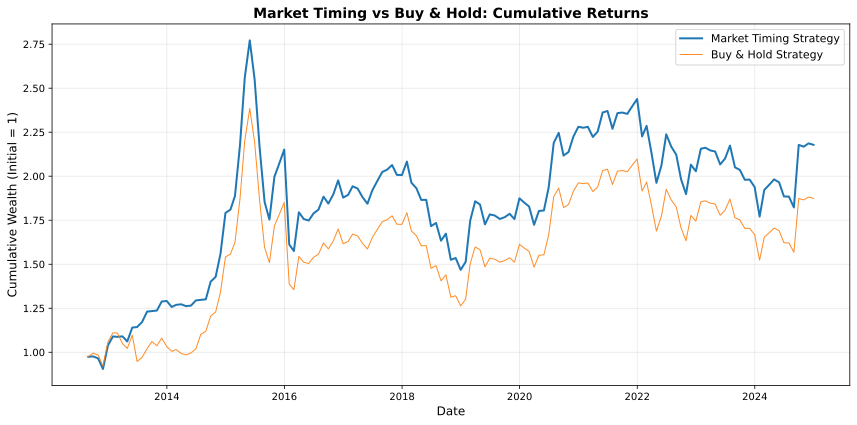

In [27]:
# 可视化累计收益对比
plt.figure(figsize=(12, 6))
plt.plot(timing_results.index, timing_results['timing_cum'], label='Market Timing Strategy', linewidth=2)
plt.plot(timing_results.index, timing_results['buy_hold_cum'], label='Buy & Hold Strategy', linewidth=1, alpha=0.9)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Wealth (Initial = 1)', fontsize=12)
plt.title('Market Timing vs Buy & Hold: Cumulative Returns', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();

In [28]:
# 比较不同预测变量组合的Market Timing表现
predictor_sets = [
    (['lRV3'], 'RV3'),
    (['lcpi'], 'CPI'),
    (['lpd'], 'PD'),
    (['lRV3', 'lcpi'], 'RV3+CPI'),
    (['lRV3', 'lpd'], 'RV3+PD'),
    (['lRV3', 'lcpi', 'lpd'], 'RV3+CPI+PD')
]

comparison_results = {}

print("\n" + "="*100)
print("不同预测变量组合的Market Timing策略对比")
print("="*100)
print(f"{'模型':<15} {'累计收益':<12} {'年化收益':<12} {'波动率':<12} {'夏普比率':<12} {'最大回撤':<12} {'胜率':<10}")
print("-"*100)

for predictors, name in predictor_sets:
    results = market_timing(reg_data['2000-01':'2024-12'], 'ret', predictors, initial_sample_fraction=1/2)
    metrics = calculate_strategy_metrics(results)
    comparison_results[name] = {
        'results': results,
        'metrics': metrics
    }
    
    print(f"{name:<15} {metrics['Timing Cumulative Return']:>11.4f} {metrics['Timing Annualized Return']:>11.4f} "
          f"{metrics['Timing Volatility']:>11.4f} {metrics['Timing Sharpe Ratio']:>11.4f} "
          f"{metrics['Timing Max Drawdown']:>11.4f} {metrics['Hit Rate']:>9.4f}")

# Buy & Hold 基准
buy_hold_metrics = calculate_strategy_metrics(timing_results)
print("-"*100)
print(f"{'Buy & Hold':<15} {buy_hold_metrics['Buy&Hold Cumulative Return']:>11.4f} "
      f"{buy_hold_metrics['Buy&Hold Annualized Return']:>11.4f} "
      f"{buy_hold_metrics['Buy&Hold Volatility']:>11.4f} {buy_hold_metrics['Buy&Hold Sharpe Ratio']:>11.4f} "
      f"{buy_hold_metrics['Buy&Hold Max Drawdown']:>11.4f} {'N/A':>9}")
print("="*100)


不同预测变量组合的Market Timing策略对比
模型              累计收益         年化收益         波动率          夏普比率         最大回撤         胜率        
----------------------------------------------------------------------------------------------------
RV3                  0.5951      0.0383      0.2003      0.1913     -0.4703    0.4966
CPI                  0.4596      0.0309      0.2062      0.1499     -0.4822    0.5235
PD                   0.8742      0.0519      0.2131      0.2435     -0.4703    0.5369
RV3+CPI              0.5296      0.0348      0.1913      0.1820     -0.4554    0.5034
RV3+PD               1.1783      0.0647      0.2063      0.3136     -0.4703    0.5369
RV3+CPI+PD           0.5191      0.0343      0.2058      0.1664     -0.4822    0.5235
----------------------------------------------------------------------------------------------------
Buy & Hold           0.8742      0.0519      0.2131      0.2435     -0.4703       N/A


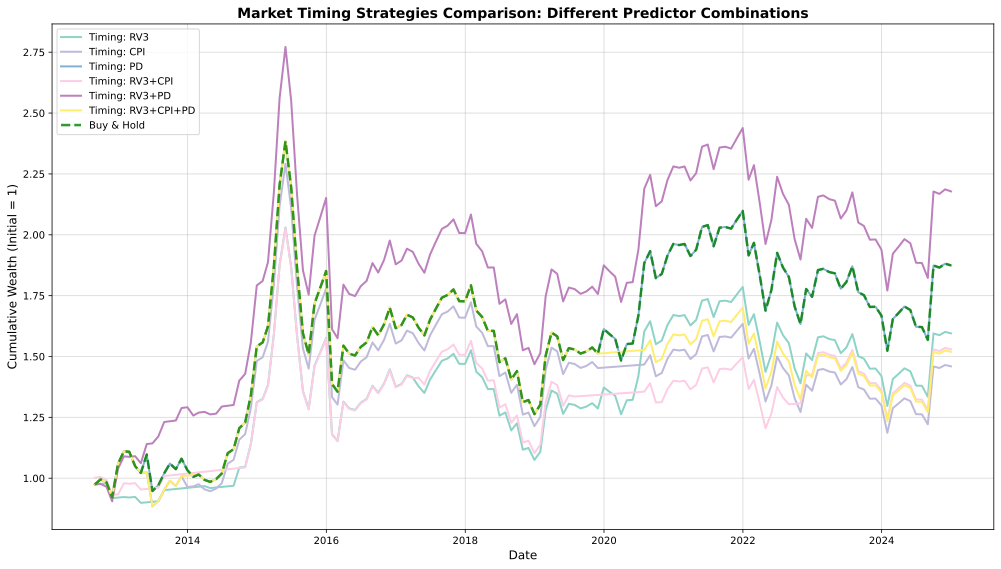

In [35]:
# 绘制所有策略的累计收益对比图
plt.figure(figsize=(14, 8))

# 绘制所有Market Timing策略
colors = plt.cm.Set3(np.linspace(0, 1, len(predictor_sets)))
for (predictors, name), color in zip(predictor_sets, colors):
    results = comparison_results[name]['results']
    plt.plot(results.index, results['timing_cum'], label=f'Timing: {name}', linewidth=2, color=color)

# 绘制Buy & Hold
plt.plot(timing_results.index, timing_results['buy_hold_cum'], 
         label='Buy & Hold', linewidth=2.5, color='green', linestyle='--', alpha=0.8)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Wealth (Initial = 1)', fontsize=12)
plt.title('Market Timing Strategies Comparison: Different Predictor Combinations', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show();

# 季度数据样本外预测

除了月度数据，我们也可以使用季度数据进行样本外预测。季度数据的优势：
1. 减少噪音
2. 降低换仓频率
3. 减少交易成本

缺点：
1. 样本量减少
2. 预测频率降低

In [36]:
# 构建季度数据
Qreg_data = reg_data.resample('QE').apply({
    'ret': lambda x: np.exp(sum(np.log(1 + x))) - 1,
    'rfmonth': lambda x: np.exp(sum(np.log(1 + x))) - 1,
    'RV': lambda x: sum(x),
    'RV1': lambda x: sum(x),
    'RV2': lambda x: sum(x),
    'RV3': lambda x: sum(x),
    'pd': lambda x: np.mean(x),
    'pe': lambda x: np.mean(x),
    'pb': lambda x: np.mean(x),
    'cpi': lambda x: sum(x),
})

# 创建滞后变量
Qreg_data['lRV3'] = Qreg_data['RV3'].shift(1)
Qreg_data['lpd'] = Qreg_data['pd'].shift(1)
Qreg_data['lpe'] = Qreg_data['pe'].shift(1)
Qreg_data['lpb'] = Qreg_data['pb'].shift(1)
Qreg_data['lcpi'] = Qreg_data['cpi'].shift(1)
Qreg_data

,ret,rfmonth,RV,RV1,RV2,RV3,pd,pe,pb,cpi,lRV3,lpd,lpe,lpb,lcpi
month,,,,,,,,,,,,,,,
1991-03-31,-0.082992,0.020934,0.002337,0.005198,0.008096,0.010593,NaN,4.359895,1.863225,4.800000e+00,NaN,NaN,NaN,NaN,NaN
1991-06-30,-0.231732,0.018953,0.006177,0.008025,0.008207,0.010588,NaN,4.220148,1.920373,9.300000e+00,0.010593,NaN,4.359895,1.863225,4.800000e+00
1991-09-30,-0.196257,0.018388,0.119336,0.114575,0.105919,0.105381,NaN,4.677239,1.937627,1.410000e+01,0.010588,NaN,4.220148,1.920373,9.300000e+00
1991-12-31,1.182164,0.018388,0.155513,0.176020,0.199149,0.234951,inf,4.791900,2.360741,1.370000e+01,0.105381,NaN,4.677239,1.937627,1.410000e+01
1992-03-31,0.221498,0.018388,0.007081,0.010983,0.012579,0.013985,inf,4.514303,2.492578,1.610000e+01,0.234951,inf,4.791900,2.360741,1.370000e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,-0.047820,0.003854,0.003146,0.004187,0.004378,0.004791,10.816541,2.538712,0.206497,-1.000000e+00,0.003421,10.858804,2.574209,0.278974,-2.000000e-01
2024-03-31,0.006789,0.003699,0.009678,0.012825,0.014335,0.013999,10.791440,2.516400,0.163619,-8.326673e-17,0.004791,10.816541,2.538712,0.206497,-1.000000e+00
2024-06-30,-0.034157,0.003604,0.004243,0.002390,0.003917,0.003171,10.815617,2.587507,0.169407,8.000000e-01,0.013999,10.791440,2.516400,0.163619,-8.326673e-17


In [ ]:
# 季度数据的样本外预测
data = Qreg_data['2000-01':'2024-12'].copy()
data = data.dropna()  # 删除缺失值
benchmark = 0.00
augment = 0.00
ab = 0.00

for i in range(int(len(data) / 3), len(data) - 1):
    data_reg = data[0:i]
    model1 = smf.ols('ret ~ lRV3', data_reg).fit(displ=False)
    r_a = (model1.predict(data[i:i + 1][['lRV3']]) - data[i:i + 1]['ret'])**2
    r_b = (np.mean(data[0:i]['ret']) - data[i:i + 1]['ret'])**2
    r_ab = (model1.predict(data[i:i + 1][['lRV3']]) - data[i:i + 1]['ret']) * (
        np.mean(data[0:i]['ret']) - data[i:i + 1]['ret'])
    # 提取数值（从Series转为numpy数组，避免索引干扰）
    r_a = r_a.values
    r_b = r_b.values
    r_ab = r_ab.values
    augment = augment + r_a
    benchmark += r_b
    ab += r_ab

oos = 1 - augment / benchmark
ENCNEW = ((benchmark - ab) / augment) * (len(data) - int(len(data) / 3))
MSEF = (benchmark - augment) / augment * (len(data) - int(len(data) / 3))

print('季度数据 - 使用RV3预测:')
print(f'样本外的R方是 {oos[0]:.6f}')
print(f'样本外的ENC-NEW是 {ENCNEW[0]:.6f}')
print(f'样本外的MSE-F是 {MSEF[0]:.6f}')

季度数据 - 使用RV3预测:
样本外的R方是 -0.100148
样本外的ENC-NEW是 -1.013438
样本外的MSE-F是 -6.099112


# 总结与思考

## 主要发现

### 1. 样本外预测能力
- 已实现波动率(RV3)对市场收益率具有一定的样本外预测能力
- 多变量模型通常优于单变量模型
- 初始样本比例的选择会影响预测表现

### 2. Market Timing策略
- 基于预测模型的择时策略可能优于Buy & Hold
- 策略表现高度依赖于预测变量的选择
- 交易成本显著影响策略的实际收益

### 3. 实践启示
- **样本外验证的重要性**: 样本内R²可能高估模型的真实预测能力
- **交易成本不可忽视**: 高频交易策略需要考虑实际交易成本
- **稳健性检验**: 需要在不同时间段和市场条件下验证策略

## 进一步研究方向

1. **机器学习方法**: 尝试使用随机森林、神经网络等方法
2. **动态调仓**: 根据预测置信度动态调整仓位
3. **风险管理**: 加入止损、仓位管理等风险控制措施
4. **多资产配置**: 扩展到多资产择时策略

## 注意事项

⚠️ **重要提醒**:
- 历史表现不代表未来收益
- 所有策略都存在模型风险和市场风险
- 实际应用需要考虑更多实务问题（流动性、冲击成本等）
- 本notebook仅供学习研究，不构成投资建议